In [1]:
machine = 'mac'
machine = 'magny'


In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import copy

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind

import sys
sys.path.append("../../arepo-snap-util/build/lib.linux-x86_64-3.6/areposnap/")
from parse_particledata import parse_particledata

from scipy.optimize import curve_fit

from galpy.potential import plotDensities, evaluateDensities, plotPotentials
from galpy.potential import MiyamotoNagaiPotential as MP
from galpy.potential import HernquistPotential as HP
from galpy.util import bovy_conversion

from auriga_basics import *

from astropy import units as u
%matplotlib inline

In [23]:
level = 4
if machine == 'magny':
    filedir = "/home/extmilan/masterthesis/files/"
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
    plotdir = "/home/extmilan/masterthesis/plots/"
elif machine == 'mac':
    filedir = "/Users/smilanov/Documents/masterthesis/auriga_files/files/"
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
    plotdir = "/Users/smilanov/Documents/masterthesis/auriga_files/plots/"
else:
    raise NotADirectoryError
j = 0
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(127,128,1):
        print("level   : {0}".format(level))
        print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print("basedir : {0}".format(basedir))
        print("halodir : {0}".format(halodir))
        print("snappath: {0}\n".format(snappath))
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[0,1,2,3,4,5], 
            haloid=0, galradfac=0.1, verbose=True) 

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
     

level   : 4
halo    : 24
snapnr  : 127
basedir : /hits/universe/GigaGalaxy/level4_MHD/
halodir : /hits/universe/GigaGalaxy/level4_MHD/halo_24/
snappath: /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/

[ 34.42281723  33.16259384  37.29567337]
Found 1783163 stars.
Rotated pos.
Rotated bfld.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]



In [4]:
cmap = copy.copy(plt.cm.inferno)
cmap.set_bad((0,0,0))  # Fill background with black

galrad = s.galrad
Gcosmo = 43.0071


Try to distinguish stellar disc and spheroid components by the use of the circularity parameter $\epsilon = \frac{L_z}{L_{z,max}(E)}$.

$L_{z,max}(E)$ is the maximum angular momentum allowed for the orbital energy $E$. 

$\rightarrow \epsilon = 1$ is a prograde circular orbit in the disc plane. $\epsilon = -1$ is a retrograde circular orbit in the disc plane. $\epsilon \sim 0$ is an orbit with a very low $z$-component of angular momentum which may be highly inclined to the disc spin axis and/or be highly eccentric.  

Two methods two distinguish the components:
1. Mirror negative $\epsilon$ as bulge material, rest disc components.
2. Assign $\epsilon > 0.7$ to disc star particles.

see Grand et al. 2017

In [40]:
#fig, ax = plt.subplots(1, 1, figsize=(8,6))
def MNdens(x, a_kpc, b_kpc, first_fac_kpc2):
    '''
    INPUT: 
        x: R_kpc, z_kpc, Mass_tot
    '''
    z_kpc = 0
    R_kpc = x
    #first_fac_kpc2 = (mass_10Msun * b_kpc**2) / (4. * np.pi) # * 10^10M_sun
    bzsqrt_kpc = np.sqrt(z_kpc**2 + b_kpc**2)
    abz_sqrt_kpc = (a_kpc + bzsqrt_kpc)
    numerator_kpc3 = a_kpc * R_kpc**2 + (a_kpc + 3. * bzsqrt_kpc) * abz_sqrt_kpc**2
    denominator_kpc8 = (R_kpc**2 + abz_sqrt_kpc**2)**(5./2.) * bzsqrt_kpc**3
    rho_kpc_3 = first_fac_kpc2 * numerator_kpc3 / denominator_kpc8 # * 10^10 M_sun if not specific density
    return(rho_kpc_3)

def MNdensgalpy(rbin,a_kpc,b_kpc):
    galpydens = np.zeros(len(rbin))
    mp= MP(a=a_kpc/8.,b=b_kpc/8.,normalize=1.)
    for i,item in enumerate(rbin):       
        galpydens[i] = evaluateDensities(mp, item/8., 0.)*bovy_conversion.dens_in_msolpc3(150.,8.)
    return galpydens

def MND_HB(x, a_MN_kpc, b_MN_kpc, a_H_kpc):
    rbin = x[0]
    disk_mass_Msol = x[1]
    bulge_mass_Msol = x[2]
    galpydens = np.zeros(len(rbin))
    mp = MP(amp = disk_mass_Msol, a = a_MN_kpc/8.,b=b_MN_kpc/8.)
    hp = HP(amp = bulge_mass_Msol, a = a_H_kpc/8.)
    pot = [mp, hp]
    for i,item in enumerate(rbin):       
        galpydens[i] = evaluateDensities(pot, item/8., 0.)*bovy_conversion.dens_in_msolpc3(220.,8.)
    return galpydens   


def decomp(s, circ_val = 0.6, plotter = False):
    ID = s.id
    # get number of particles 
    na = s.nparticlesall

    # get mass and age of stars 
    mass = s.data['mass'].astype('float64')
    st = na[:4].sum(); en = st+na[4]
    age = np.zeros( s.npartall )
    # only stars will be given an age, for other particles: age = 0
    age[st:en] = s.data['age']

    # create masks for all particles / stars within given radius
    iall, = np.where( (s.r() < galrad) & (s.r() > 0.) )
    istars, = np.where( (s.r() < galrad) & (s.r() > 0.) & (s.type == 4) & (age > 0.) )

    # calculate radius of all particles within galrad, sort them, \
    # get their mass and calculate their cumulative mass sorted by their distance
    nstars = len( istars )
    nall   = len( iall )
    rr = np.sqrt( (s.pos[iall,:]**2).sum(axis=1) )
    msort = rr.argsort()
    mass_all = mass[iall]
    msum = np.zeros( nall )
    msum[msort[:]] = np.cumsum(mass_all[msort[:]])

    # get position, velocity, mass, type, potential, radius and age of all particles within galrad
    pos  = s.pos[iall,:].astype( 'float64' )
    vel = s.vel[iall,:].astype( 'float64' )
    mass = s.data['mass'][iall].astype( 'float64' )
    ptype = s.data['type'][iall]
    pot = s.data['pot'][iall].astype('float64')
    radius = np.sqrt( (s.pos[iall,:]**2).sum(axis=1) )
    Radius = np.sqrt((s.pos[iall,2]**2 + s.pos[iall,1]**2))
    age = age[iall]

    # create zero arrays with the length = number of stars for values to be calculated
    eps   = np.zeros( nstars )
    eps2  = np.zeros( nstars )
    smass = np.zeros( nstars )
    cosalpha = np.zeros( nstars )
    jcmax = np.zeros( nstars )
    spec_energy = np.zeros( nstars )
    star_age = np.zeros( nstars )

    # computing stellar properties
    print('computing star properties')

    # another mask for star selection
    nn, = np.where((ptype[:] == 4) & (age[:] > 0.)) 

    # calculate specific angular momentum (w/o considering mass)
    j  = np.cross( pos[nn,:], vel[nn,:] ) #!!!! Check if x, y, z position is the right way
    # calculate circular orbit angular momentum
    jc = radius[nn] * np.sqrt( Gcosmo * msum[nn] / radius[nn] )
    # get z-component of specific angular momentum !! CHECK AGAIN XYZ 
    jz = j[:,0]

    # calculate specific energy
    spec_energy[:] = 0.5 * (vel[nn,:]**2).sum(axis=1) + pot[nn]
    # circularity parameter eps = j_z / j_circ
    eps[:] = jz / jc
    eps2[:] = jz
    smass[:] = mass[nn]
    # calculate normed Jz??
    cosalpha[:] = jz / np.sqrt( (j[:]**2).sum(axis=1) )
    # calculate age from cosmology
    star_age[:] = s.cosmology_get_lookback_time_from_a( age[nn], is_flat=True )

    print('computing histograms')

    # sort particle by specific energy
    iensort = np.argsort(spec_energy)
    eps = eps[iensort]
    eps2 = eps2[iensort]
    spec_energy = spec_energy[iensort]
    smass = smass[iensort]
    cosalpha = cosalpha[iensort]
    star_age = star_age[iensort]

    # find maximum allowed J_circ for each energy for each star 
    #(look at 100 stars around selected star and find the maximum jz within them)
    for nn in range( nstars ):
        nn0 = nn - 50
        nn1 = nn + 50

        if nn0 < 0:
            nn1 += -nn0
            nn0 = 0
        if nn1 >= nstars:
            nn0 -= ( nn1 - (nstars - 1) )
            nn1 = nstars - 1

        jcmax[nn] = np.max( eps2[nn0:nn1] )
    nn, = np.where((ptype[:] == 4) & (age[:] > 0.)) 

    # divide star mass by mass of all stars to use as weight in histogram
    smass /= smass.sum()
    # calculate eps = jz/j_z_max 
    eps2[:] /= jcmax[:]
    
    Radius_Mpc = s.r()[istars][iensort]
    
    zmax = 0.0005
    ii = (eps2 >= circ_val) #& (abs(pos[:,0][nn]) < zmax)
    jj = (eps2 < circ_val)
    idisk = np.where((eps2 >= circ_val) & (abs(pos[:,0][nn]) < zmax))
    ispheroid = np.where(eps2 < circ_val)
    disk_ID = ID[istars][iensort][idisk]
    disk_ID = ID[nn][ii]
    spheroid_ID = ID[istars][iensort][ispheroid]
  
    
    if plotter == True:
        fig, ax = plt.subplots(1, 1, figsize=(8,6))
        
        ydatatot, edges = np.histogram( eps2, bins=100, weights=smass, range=[-1.7,1.7] )
        xdatatot = 0.5 * (edges[1:] + edges[:-1])
        xdata = xdatatot

        ydatad, edgesd = np.histogram( eps2[idisk], bins=100, weights=smass[idisk], range=[-1.7,1.7] )
        ydatas, edgess = np.histogram( eps2[ispheroid], bins=100, weights=smass[ispheroid], range=[-1.7,1.7] )

        ax.fill( xdata, ydatad, fc='b', alpha=0.5, fill=True, lw=0, label='disc' )
        ax.fill( xdata, ydatas, fc='y', alpha=0.5, fill=True, lw=0, label='spheroid' )
        
        ax.plot( xdatatot, ydatatot, 'k', label='total' )
        ax.legend()
        ax.set_xlabel('$\epsilon$')
        plt.show()
    nr = 30
    #print(mass)
    #print(radius)
    #print(len(mass), len(radius))
    #print(nn, len(nn), np.sum(nn))
    #print(ii, len(ii), np.sum(ii))
    
    #
    disk_mass = np.sum(mass[nn][ii]) * 1e10 * u.Msun
    bulge_mass = np.sum(mass[nn][jj]) * 1e10 * u.Msun
    print('The disk\'s mass is {:.2e} and the bulge\'s mass is {:.2e}.'.format(disk_mass, bulge_mass))
    pn, edges = np.histogram( Radius[nn][ii], bins=nr, weights=mass[nn][ii], range=[0., galrad] )
    #pn, edges = np.histogram( radius[nn], bins=nr, weights=mass[nn], range=[0., galrad] )
    rbin = 0.5 * (edges[:-1] + edges[1:])
    vol = np.pi * (edges[1:]**2 - edges[:-1]**2)
    rho = 1e-5 * pn / vol
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    sigma = rho
    ax.semilogy(rbin*1e3,rho,color='k',marker='o', markersize=2., linewidth=0.)
    #plt.plot(rbin*1e3, MNdens(rbin*1e3, 5, 1, 1), 'b')
    #plt.plot(rbin*1e3, MNdens(rbin*1e3, 4, 4, 10), 'g')
    
    #plt.plot(rbin*1e3, galpydens, 'r')
    #plt.plot(rbin*1e3, MNdens(rbin*1e3, 10, 2, 1), 'r')
    x = [rbin*1e3, disk_mass, bulge_mass]
    #(poptd, pcovd) = curve_fit( MND_HB, x, rho, (5., 1., 1.), bounds = ([0., 0., 0.],[10., 10., 10.]))#, sigma = 1./rho)# sigma = rho,, (0.1, 3., 1.), sigma=sigma, bounds=([0., 0.5], [10., 10.], [None,None]) )
    (poptd, pcovd) = curve_fit( MNdensgalpy, rbin*1e3, rho, (5., 1.), bounds = ([0., 0.],[10., 10.]), sigma = 1/rho)# sigma = rho,, (0.1, 3., 1.), sigma=sigma, bounds=([0., 0.5], [10., 10.], [None,None]) )
    print(poptd, pcovd)
    a_MND_kpc   = 2.96507719743
    b_MND_kpc   = 1.63627757204

    ax.plot(rbin*1e3, MNdensgalpy(rbin*1e3, a_MND_kpc, b_MND_kpc), 'r')
    ax.set_xlabel("R [kpc]", fontsize = 18)
    ax.set_ylabel('$rho [M_{sun}/pc^3]$', fontsize = 18)
    #plt.plot(rbin*1e3, MND_HB(x, *poptd), 'r')
    plt.savefig(plotdir + 'disk_density_fit_{}_circularity_edge.png'.format(circ_val), dpi = 300, format = 'png' )
    plt.show()
    #a_MN_kpc = poptd[0]
    #b_MN_kpc = poptd[1]
    #a_H_kpc  = poptd[2]
    #mp = MP(a=a_MN_kpc/8.,b=b_MN_kpc/8.,normalize=0.7)
    #hp = HP(a_H_kpc/8., normalize=0.3)
    #pot = [mp, hp]    
    #plotPotentials(pot)
    return(disk_ID, spheroid_ID, rho, poptd)

circular limit = 0.7
computing star properties
computing histograms
The disk's mass is 3.13e+10 solMass and the bulge's mass is 3.42e+10 solMass.
[  1.56712236e-15   2.54925895e+00] [[ 0.92344053 -0.79956355]
 [-0.79956355  0.69264492]]


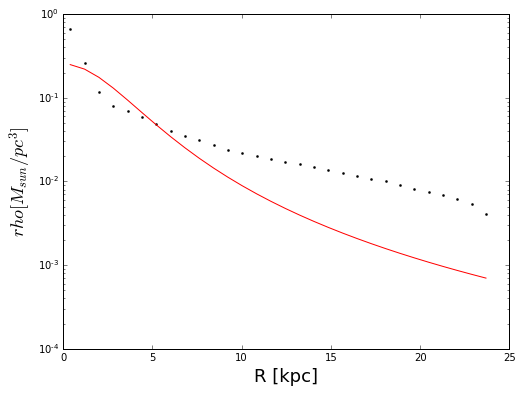

In [41]:
#for i in [0.4,0.5,0.6,0.7,0.8]:
for i in[ 0.7]:
    print("circular limit = {}".format(i))
    disk_ID, spheroid_ID, rho, poptd = decomp(s, plotter = 0, circ_val=i)
#print(ID.shape, eps2.shape, istars.shape)


In [7]:
i_spher = np.isin(s.id, spheroid_ID)
z_spher, y_spher, x_spher = s.pos[:,0][i_spher], s.pos[:,1][i_spher], s.pos[:,2][i_spher]
r_spher = s.r()[i_spher]
R_spher = np.sqrt(x_spher**2 + y_spher**2)
i_disk = np.isin(s.id, disk_ID)
z_disk, y_disk, x_disk = s.pos[:,0][i_disk], s.pos[:,1][i_disk], s.pos[:,2][i_disk]
r_disk = s.r()[i_disk]
R_disk = np.sqrt(x_disk**2 + y_disk**2)


In [8]:
print(np.mean(1000* R_spher))
print(len(np.where((1000*R_spher) < 1.)[0]))
print(len(np.where((1000*R_spher) > 1.)[0]))
#print(len(bulge_ID), len(halo_ID))

4.19912
385338
712828


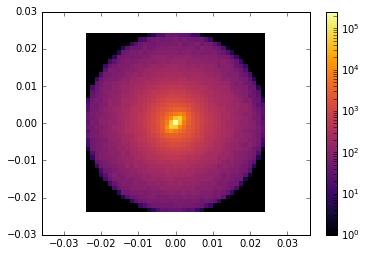

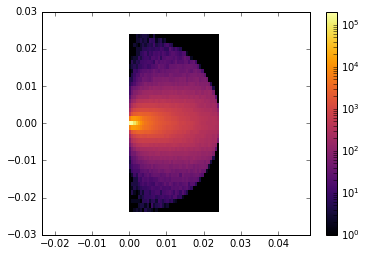

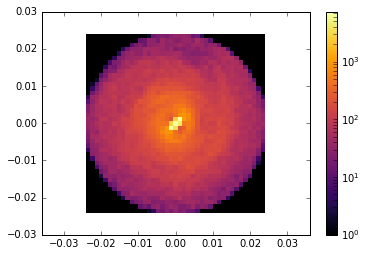

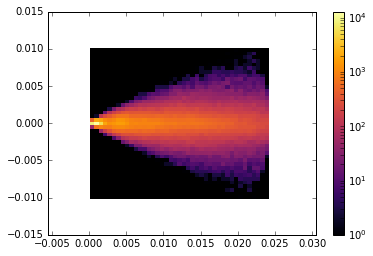

In [9]:
plt.hist2d(x_spher, y_spher, bins = 41, norm=colors.LogNorm(), cmap = cmap)
plt.axis('equal')
plt.colorbar()
#plt.xlim(0,0.1)
#plt.axis(0, 0.10, -0.1, 0.1)
plt.show()

plt.hist2d(R_spher, z_spher, bins = 41, norm=colors.LogNorm(), cmap = cmap)
plt.axis('equal')
plt.colorbar()
#plt.xlim(0,0.1)
#plt.axis(0, 0.10, -0.1, 0.1)
plt.show()

plt.hist2d(x_disk, y_disk, bins = 41, norm=colors.LogNorm(), cmap = cmap)
plt.axis('equal')
plt.colorbar()
#plt.xlim(0,0.1)
plt.show()

plt.hist2d(R_disk, z_disk, bins = 41, norm=colors.LogNorm(), cmap = cmap)
plt.axis('equal')
plt.colorbar()
#plt.xlim(0,0.1)
plt.show()